# Flavor Preference: Part 2

Will ask Jane about their flavor offering decisions rationale when we talk next. Some analysis in the mean time: 

Litres consumed per flavor might not an accurate measure of flavor preference because people had little choice in the three flavors they got to chose from at any time.

Inverse time is can be a good measure of preference! If the flavor is offered, how quickly is chosen and consumed. Lets explore that here.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

%matplotlib inline

In [3]:
#import the data that combined stations and country, and was processed in LifeSoda_analysis.ipynb
combined=pd.read_csv('data/combined_data.csv')
combined.head() #reminder

amount_vended_L  flavor_id    flavor_name  tank_level_after  \
0              1.0          7        coconut             999.0   
1              0.5          7        coconut             998.5   
2              1.0         18  earl_grey_tea             997.5   
3              1.0          7        coconut             996.5   
4              1.0         21      blueberry             995.5   

             timestamp  statn   F1   F2   F3 country  
0  2019-01-01 01:00:00      4  499  500  500     BRY  
1  2019-01-01 01:45:00      4  498  500  500     BRY  
2  2019-01-01 02:30:00      4  498  500  499     BRY  
3  2019-01-01 02:56:00      4  497  500  499     BRY  
4  2019-01-01 03:22:00      4  497  499  499     BRY

In [41]:
#To do: convert to function, do for F1,F2,F3 using the fxn instead of 3 separate.
#Store and import because running this takes quite long.
'''
F1=pd.DataFrame(columns=['statn','flavor','start_time','stop_time','stop_level']) #Assuming start level is always 499
j=0
for i in range(len(combined.F1)-1):
    if combined.F1[i]==499:
        F1.loc[j,'statn']=combined.statn[i]
        F1.loc[j,'start_time']=combined.timestamp[i]
    elif combined.F1[i]<combined.F1[i+1]:
        F1.loc[j,'flavor']=combined.flavor_name[i]
        F1.loc[j,'stop_level']=combined.F1[i]
        F1.loc[j,'stop_time']=combined.timestamp[i]
        j=j+1
        
F2=pd.DataFrame(columns=['statn','flavor','start_time','stop_time','stop_level']) #Assuming start level is always 499
j=0
for i in range(len(combined.F2)-1):
    if combined.F2[i]==499:
        F2.loc[j,'statn']=combined.statn[i]
        F2.loc[j,'start_time']=combined.timestamp[i]
    elif combined.F2[i]<combined.F2[i+1]:
        F2.loc[j,'flavor']=combined.flavor_name[i]
        F2.loc[j,'stop_level']=combined.F2[i]
        F2.loc[j,'stop_time']=combined.timestamp[i]
        j=j+1
        
F3=pd.DataFrame(columns=['statn','flavor','start_time','stop_time','stop_level']) #Assuming start level is always 499
j=0
for i in range(len(combined.F3)-1):
    if combined.F3[i]==499:
        F3.loc[j,'statn']=combined.statn[i]
        F3.loc[j,'start_time']=combined.timestamp[i]
    elif combined.F3[i]<combined.F3[i+1]:
        F3.loc[j,'flavor']=combined.flavor_name[i]
        F3.loc[j,'stop_level']=combined.F3[i]
        F3.loc[j,'stop_time']=combined.timestamp[i]
        j=j+1
        
flav_time = pd.concat([F1,F2,F3], ignore_index=True)
flav_time.dropna(inplace=True)
flav_time=flav_time[flav_time.flavor!='water']
flav_time.head()


flav_time.to_csv('data/flav_time.csv',index=False)
'''

In [10]:
flav_time = pd.read_csv('data/flav_time.csv')
flav_time.head()

statn      flavor           start_time            stop_time  stop_level
0      4       mango  2019-01-10 06:27:00  2019-01-15 09:35:00           9
1      4   raspberry  2019-01-21 08:30:00  2019-01-24 15:33:00           9
2      4        acai  2019-01-24 15:46:00  2019-01-30 22:09:00           9
3      4  blackberry  2019-01-30 22:35:00  2019-02-04 09:28:00           9
4      4  strawberry  2019-02-04 09:38:00  2019-02-11 16:40:00           9

In [11]:
# How many days between flavor start and end?
flav_time.start_time=pd.to_datetime(flav_time.start_time)
flav_time.stop_time=pd.to_datetime(flav_time.stop_time)
flav_time['del_time']=flav_time.stop_time-flav_time.start_time
flav_time['del_time_days']=[i/dt.timedelta(days=1) for i in flav_time.del_time]
flav_time.drop(columns=['start_time','stop_time','del_time'],inplace=True)

#For flavors that were replaced before they were cosumed down to level zero, the time is scaled proportionally
#Eg. If it took 8 days from level to go from 500 to 100, and then the flavor was replaced (level of dispenser..
#goes up to 499; replacement is another or same flavor), the time for the former flavor to go down to zero..
# would've been 10 days.

flav_time['days_norm']=[flav_time.del_time_days[i]*500/(500-flav_time.stop_level[i]) for i in range(len(flav_time))]
flav_time.head()

statn      flavor  stop_level  del_time_days  days_norm
0      4       mango           9       5.130556   5.224598
1      4   raspberry           9       3.293750   3.354124
2      4        acai           9       6.265972   6.380827
3      4  blackberry           9       4.453472   4.535104
4      4  strawberry           9       7.293056   7.426737

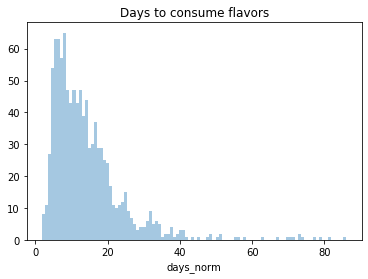

In [12]:
#Plot days to consume flavors fully. Higher numbers cropped in the graph.
crop=flav_time.days_norm[flav_time.days_norm<90]
sns.distplot(crop,kde=False,bins=100)
plt.title('Days to consume flavors');

In [13]:
#Pivot table of number of days!
table = pd.pivot_table(flav_time, values='days_norm', index=['flavor'],columns=['statn'], aggfunc=np.mean)
table

statn                 0          1           2           3          4   \
flavor                                                                   
acai           15.468715        NaN   14.971572         NaN  39.588811   
blackberry           NaN   8.050464   20.756926         NaN   4.339924   
blueberry      32.226655        NaN         NaN         NaN   5.071811   
cherry         27.482179        NaN   15.903068         NaN        NaN   
coconut              NaN        NaN   21.257637         NaN        NaN   
cranberry      17.081778        NaN         NaN    7.129017        NaN   
cucumber       24.164914   8.138153   10.189310         NaN   2.190824   
earl_grey_tea        NaN  14.553927         NaN  117.270710   9.666591   
eucalyptus           NaN  44.160982         NaN         NaN  14.466650   
grapefruit           NaN   9.345299         NaN         NaN   4.049276   
green_tea            NaN   6.697994    8.464160    6.818214   2.192238   
key_lime             NaN        NaN  352.700761         NaN   3.211982   
lemon                NaN   7.237921         NaN    6.935958        NaN   
lemon_lime     16.003338        NaN         NaN         NaN        NaN   
lemonade             NaN   5.985517         NaN         NaN        NaN   
lime           12.128027   6.183526         NaN    7.046631        NaN   
mackerel             NaN        NaN         NaN         NaN  56.223835   
mango                NaN   7.965603   19.642361         NaN   5.224598   
mint           24.836643  19.859921         NaN         NaN  10.374943   
oolong         21.037706        NaN         NaN    6.402396   3.465858   
orange               NaN  11.684629         NaN         NaN        NaN   
peach          25.888210        NaN   31.751740         NaN   5.838325   
pear                 NaN  14.649059         NaN    6.815385   4.562330   
pine_needle    16.932316        NaN         NaN         NaN        NaN   
pomegranate          NaN  11.957598   33.080556    7.508062   6.066135   
raspberry            NaN        NaN         NaN         NaN   2.774595   
strawberry     23.816191        NaN    9.960540    7.129017   5.911617   
tuna_fish            NaN   7.034963         NaN         NaN        NaN   

statn                 5           6          7            8          9   ...  \
flavor                                                                   ...   
acai           15.192917         NaN  10.713790          NaN  17.151788  ...   
blackberry     17.436779  212.859322   5.209041    13.403768  12.417261  ...   
blueberry      32.324197    7.601393        NaN          NaN   9.531993  ...   
cherry               NaN    5.268443        NaN          NaN        NaN  ...   
coconut              NaN         NaN   5.638295    13.543788        NaN  ...   
cranberry            NaN    5.324310        NaN          NaN        NaN  ...   
cucumber       24.596007         NaN        NaN          NaN        NaN  ...   
earl_grey_tea  25.886796   25.154983        NaN          NaN  10.853700  ...   
eucalyptus           NaN   12.211784   5.415535          NaN  45.409736  ...   
grapefruit           NaN         NaN        NaN    10.761767        NaN  ...   
green_tea      20.999751         NaN   4.850504    11.254667  12.489746  ...   
key_lime             NaN    4.722505  13.999420    19.590872        NaN  ...   
lemon                NaN    7.519730        NaN          NaN        NaN  ...   
lemon_lime     24.366427         NaN   5.926822  1290.342460  16.901446  ...   
lemonade       17.920485    5.286830   5.916214          NaN        NaN  ...   
lime                 NaN    9.981808        NaN    18.281144        NaN  ...   
mackerel             NaN         NaN        NaN          NaN        NaN  ...   
mango          15.287678         NaN        NaN          NaN        NaN  ...   
mint                 NaN         NaN        NaN          NaN  17.111117  ...   
oolong               NaN   11.916935  14.448263    22.346685  20.692606  ...   
orange         26.9

## Speed of consumption ~ Rating

Yay we have a pivot table with avg days to consume 500 units of flavor at each station. More liked a flavor, less the number of days to consume it! Each station has different rates of total consumption, so we weigh flavors by the minimum number of days taken to consume the most favorite flavor at that station, to standardize to consumption.

Note, standardization usually is performed as x_standardized=(x-x_mean)/(x_max-x_min). But in this case, scaling by fastest consumed makes most sense. 
Another note, this might not work well if two favorite flavors were available at the same time. eg. Station X would've picked key_lime over pear and raspberry, but because lemonade was available, key_lime consumption was slow.

Then, lets take the inverse of time to convert this to a scale of 0-5 "rating": a more familiar and intuitive scale. If necessary, we'll do 1/log(time) or 1/time^2. Starting with 1/normalized_time, and scaling 0-5 for now.

In [14]:
rating=pd.DataFrame()
for column in table:
    rating[column]=round(5/(table[column]/np.nanmin(table[column])),1)

In [17]:
cmap=sns.diverging_palette(5, 250, as_cmap=True) #light_palette("seagreen",as_cmap=True)
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "5pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
rating.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '100px', 'font-size': '4pt'})\
    .set_caption("Hover to magnify")\
    .set_precision(2)\
    .set_table_styles(magnify()).highlight_null('white')

Green tea, strawberry, and lime have a lowest rating of 2, so are more broadly liked than others. But there is no flavor that everyone likes unanimously!  Perhaps certain stations have similar taste. Time to order by country! There might be some (very few) dispenser malfunctions in there too.
cmap only seems to take 1 axis. Ideally, we'd have the same color scale across rows and columns. Can look into this later.

In [19]:
#Order columns (stations) by country. Remember metadata.csv?
station=pd.read_csv('data/metadata.csv')
station=station.sort_values(by=['country','id'])
rating_country=rating[station.id.to_list()]

rating_country.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '100px', 'font-size': '4pt'})\
    .set_caption("Hover to magnify")\
    .set_precision(2)\
    .set_table_styles(magnify()).highlight_null('white')
#Would be great to add country atop groups of columns

Adjacent columns should've looked similar, but don't really. Hmm. Well, a simplistic way to tell the 3 most liked flavor at any station is to find top 3 with highest scores (fastest consumed) at that station. Lets start with that, and we can come back to cross-station or flavor correlations later.

In [20]:
fav_three=pd.DataFrame(columns=['fav_winner','fav_rup1','fav_rup2'])
for col in rating:
    fav_three.loc[len(fav_three)]=rating.nlargest(3,[col]).index.to_list()
    
#print(fav_three.fav_winner.mode())
fav_three.head() #rup:Runner_up!

fav_winner   fav_rup1    fav_rup2
0       lime       acai  lemon_lime
1   lemonade       lime   green_tea
2  green_tea   cucumber  strawberry
3     oolong  green_tea        pear
4   cucumber  green_tea   raspberry

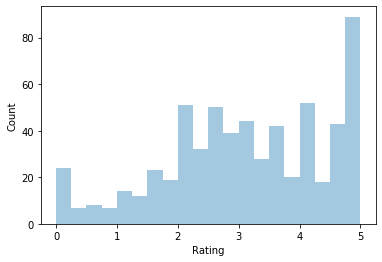

In [24]:
flat=rating.values.flatten()
sns.distplot(flat,kde=False,bins=20)
plt.xlabel('Rating');
plt.ylabel('Count');

This is not very typical of ratings data, especially the peak near 5. It happened because we set the most popular flavor at each station to rating 5.

## Correlations

Since stations from the same country were placed next to each other, we expected to see a larger blue region around the daigonal than we do. Flavor preferences seem to vary significantly. Lets see next if flavors have correlation.

Number close to 1 (blue) indicates "folks who liked flavor x also liked flavor y", -1 (red) indicates "folks who loved flavor x really disliked flavor y", and 0 (near white) indicates "there isn't really much relation. folks who like x may or may not like y.

In [37]:
rating_country.corr(method='spearman').style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '100px', 'font-size': '4pt'})\
    .set_caption("Hover to magnify")\
    .set_precision(2)\
    .set_table_styles(magnify()).highlight_null('white')


In [25]:
rating_country.transpose().corr().style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '100px', 'font-size': '4pt'})\
    .set_caption("Hover to magnify")\
    .set_precision(2)\
    .set_table_styles(magnify()).highlight_null('white')

Folks who like lemon despise key_lime, are indifferent towards lemon_lime and lime, but love lemonade. This doesn't make much sense. We should revisit our construct of Rating metric. There is a chance that data doesn't follow intuition, but we should try other rating constructs before settling there. Given limited time, lets first finish coding some recommender systems, and everything can be easily rerun with new rating definition.

## Future Work:
I'd explore:

1. Cosine similarity because Angular distance is a better measure of rating similarity than Eucleadian distance! Cosine similarity can't handle NaN, so we pad missing data with mean. Note this assumption. 
2. SVD (Matrix factorization) used in collaborative recommender systems.
3. K Nearest Neighbors

## Local flavor preferences and plan

With the analysis we have so far, we can test 3 flavors from the most similar station, and use that data to analyse performance against current top 3 at that station (in fav_three above). Since preferences vary a lot across stations, this is a better option than considering all stations' votes towards a flavor profile.